In [1]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imp
import scipy.stats
import pickle
import math
import glob
import os
import scipy.io as sio
import seaborn.apionly as sns
import matplotlib.dates as mdates
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d
from scipy.stats import circmean


%matplotlib inline  

/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 

In [2]:
folder='/Users/mdebnath/Desktop/Projects/Awaken/Awaken_data/ARM_data/'

In [3]:
DL_lidar_C1_file=folder + "DL_newsom_C1_90m_260m.csv"
DL_lidar_E37_file=folder + "DL_newsom_E37_90m_260m.csv"
DL_lidar_E39_file=folder + "DL_newsom_E39_90m_260m.csv"
ecor_C1_file= folder + "ecor_C1_data_3m.csv"
ecor_E37_file= folder + "ecor_E37_data_3m.csv"
ecor_E39_file= folder + "ecor_E39_data_3m.csv"
co2flxsoil_C1_file= folder + "co2flxsoil_C1_data.csv"
aws_data_C1_file= folder + "awsC1_10m.csv"
ecorsf_E37_file=folder + "ecorsf_E37_data.csv"
ecorsf_E39_file=folder + "ecorsf_E39_data.csv"


In [4]:
startdate = pd.to_datetime('2018-06-01')
enddate = pd.to_datetime('2020-09-01')

In [5]:
# wind shear estimation
zmax = 260 # upper bound of lidar data to use for wind profile characerization
R2_cutoff = 0.9 # threshold for rejecting fit

In [6]:
DL_C1=pd.read_csv(DL_lidar_C1_file,sep=',', header=0)
DL_E37=pd.read_csv(DL_lidar_E37_file,sep=',', header=0)
DL_E39=pd.read_csv(DL_lidar_E39_file,sep=',', header=0)
ecorsf_E37=pd.read_csv(ecorsf_E37_file,sep=',', header=0)
ecorsf_E39=pd.read_csv(ecorsf_E39_file,sep=',', header=0)
ecor_C1=pd.read_csv(ecor_C1_file,sep=',', header=0)
ecor_E37=pd.read_csv(ecor_E37_file,sep=',', header=0)
ecor_E39=pd.read_csv(ecor_E39_file,sep=',', header=0)
aws_data_C1=pd.read_csv(aws_data_C1_file,sep=',', header=0)

In [7]:
height=np.ceil(DL_C1.height.unique())
height

array([ 91., 117., 143., 169., 195., 221., 247.])

In [8]:
DL_E37.head()

,time,height,wspd,wdir,vert_ws,snr
0,2018-06-01 00:00:00,90.932671,1.356480,136.272250,0.260212,0.041740
1,2018-06-01 00:00:00,116.913437,1.649489,126.562355,0.227096,0.041512
2,2018-06-01 00:00:00,142.894196,1.815758,124.155020,0.135172,0.042390
3,2018-06-01 00:00:00,168.874969,1.917790,126.485466,0.140676,0.040832
4,2018-06-01 00:00:00,194.855728,1.909806,130.789920,-0.002747,0.042228


In [9]:
DL_C1['height']=np.ceil(DL_C1.height)
DL_E37['height']=np.ceil(DL_E37.height)
DL_E39['height']=np.ceil(DL_E39.height)

In [10]:
DL_C1.head()

,time,height,wspd,wdir,vert_ws,snr
0,2018-06-01 00:00:00,91.0,1.501558,174.72400,-0.024011,0.375512
1,2018-06-01 00:00:00,117.0,1.547697,177.09483,0.113904,0.491697
2,2018-06-01 00:00:00,143.0,1.570605,178.27069,0.243548,0.552798
3,2018-06-01 00:00:00,169.0,1.575568,161.97815,0.337331,0.569079
4,2018-06-01 00:00:00,195.0,1.714809,151.31040,0.353872,0.551492


In [11]:
DL_C1.set_index('time', inplace = True)
DL_E37.set_index('time', inplace = True)
DL_E39.set_index('time', inplace = True)

In [12]:
#df=pd.DataFrame(columns=["wspd_C1_90m","wdir_C1_90m","vert_ws_C1_90m"])
#df=pd.DataFrame()
df={}
location=["C1","E37","E39"]
colors = {"C1":"steelblue", "E37":"tomato","E39": "lightseagreen"}

In [13]:
DL_C1.index

Index(['2018-06-01 00:00:00', '2018-06-01 00:00:00', '2018-06-01 00:00:00',
       '2018-06-01 00:00:00', '2018-06-01 00:00:00', '2018-06-01 00:00:00',
       '2018-06-01 00:00:00', '2018-06-01 00:30:00', '2018-06-01 00:30:00',
       '2018-06-01 00:30:00',
       ...
       '2020-08-31 23:30:00', '2020-08-31 23:30:00', '2020-08-31 23:30:00',
       '2020-09-01 00:00:00', '2020-09-01 00:00:00', '2020-09-01 00:00:00',
       '2020-09-01 00:00:00', '2020-09-01 00:00:00', '2020-09-01 00:00:00',
       '2020-09-01 00:00:00'],
      dtype='object', name='time', length=276535)

In [14]:
for instrum in location:
    print(instrum)
    ind= eval('DL_' + instrum + '.height==height[0]')
    df[instrum] =  pd.DataFrame(index=DL_C1.index[ind], columns=[])
    print('DL_' + instrum)
    
    ind= eval('DL_' + instrum + '.height==height[0]')
    print(str(height[0]))
    df[instrum]['wspd_'+ str(int(height[0])) + 'm'] = eval('DL_' + instrum + '[ind].wspd')
    df[instrum]['wdir_'+ str(int(height[0])) + 'm'] = eval('DL_' + instrum + '[ind].wdir')
    df[instrum]['vert_ws_'+ str(int(height[0])) + 'm'] = eval('DL_' + instrum + '[ind].vert_ws')
    
    ind= eval('DL_' + instrum + '.height==height[3]')
    df[instrum]['wspd_'+ str(int(height[3])) +'m'] = eval('DL_' + instrum + '[ind].wspd')
    df[instrum]['wdir_'+ str(int(height[3])) + 'm'] = eval('DL_' + instrum + '[ind].wdir')
    df[instrum]['vert_ws_'+ str(int(height[3])) + 'm'] = eval('DL_' + instrum + '[ind].vert_ws')
    
    


C1
DL_C1
91.0
E37
DL_E37
91.0
E39
DL_E39
91.0


In [15]:
df['C1'].head()

,wspd_91m,wdir_91m,vert_ws_91m,wspd_169m,wdir_169m,vert_ws_169m
time,,,,,,
2018-06-01 00:00:00,1.501558,174.724000,-0.024011,1.575568,161.978150,0.337331
2018-06-01 00:30:00,3.300664,187.778380,0.080828,3.253631,189.273220,0.246315
2018-06-01 01:00:00,4.503373,137.623580,0.011857,4.466671,140.371060,0.014607
2018-06-01 01:30:00,5.679764,102.382256,0.108431,5.551931,111.516020,0.169127
2018-06-01 02:00:00,5.857873,106.696540,0.105633,5.724772,118.249695,0.133231


In [16]:
df['C1']['wspd_91m'].mean()

7.393924490598077

<Figure size 576x432 with 0 Axes>

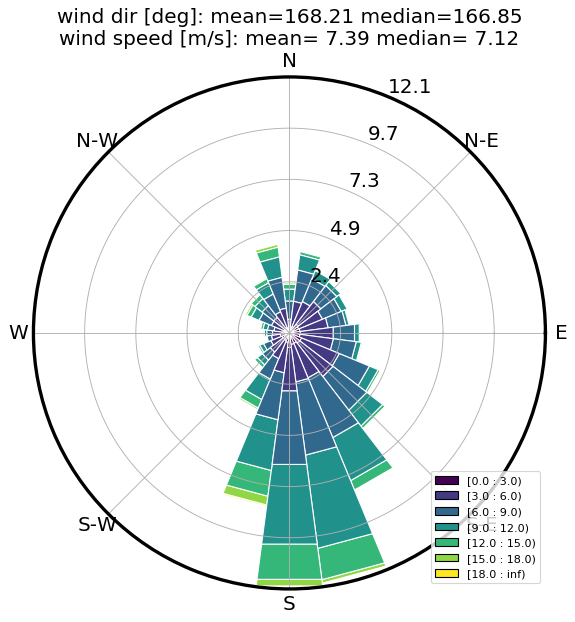

In [17]:
from windrose import WindroseAxes
import matplotlib.cm as cm

fig=plt.figure(figsize=(8,6), linewidth=3)
plt.rcParams['axes.linewidth'] = 3
ax = WindroseAxes.from_ax()
ax.bar(df['C1'].wdir_91m,df['C1'].wspd_91m, bins=np.arange(0, 21, 3), normed=True, opening=1, edgecolor='white',nsector=24, cmap=cm.viridis)

ax.set_legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('wind dir [deg]: ' + 'mean=%5.2f' %df['C1']['wdir_91m'].mean() + ' ' + 'median=%5.2f' %df['C1']['wdir_91m'].median() + '\n' + 'wind speed [m/s]: ' + 'mean=%5.2f' %df['C1']['wspd_91m'].mean() + ' ' + 'median=%5.2f' %df['C1']['wspd_91m'].median(),fontsize=18)
plt.legend(loc='lower right', decimal_places=1, units=None)
plt.bbox_inches="tight"
#filename=folder + 'figure/wind_rose_c1_91m.png'
#plt.savefig(filename,dpi=400, bbox_inches='tight', format='png')

In [18]:
mean_wdir=(df['C1'].wdir_91m.median()+df['E37'].wdir_91m.median()+df['E39'].wdir_91m.median())/3

In [19]:
#circmean(df['C1'].wdir_91m.dropna())*360/3.1416

In [20]:
df["C1"].wdir_91m.head()

time
2018-06-01 00:00:00    174.724000
2018-06-01 00:30:00    187.778380
2018-06-01 01:00:00    137.623580
2018-06-01 01:30:00    102.382256
2018-06-01 02:00:00    106.696540
Name: wdir_91m, dtype: float64

C1
E37
E39


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


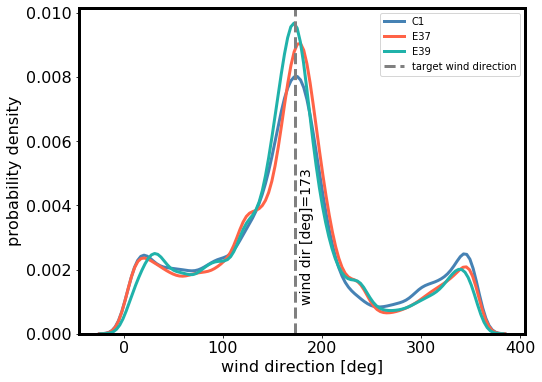

In [21]:
fig=plt.figure(figsize=(8,6), linewidth=3)
plt.rcParams['axes.linewidth'] = 3
for instrum in location:
    print(instrum)
    ax=sns.distplot(df[instrum].wdir_91m, norm_hist=True, color=colors[instrum], kde_kws=dict(linewidth=3),label=instrum, hist=False)   

ax.axvline(x=173, color='gray',linestyle='--',lw=3,label='target wind direction')
plt.xlabel('wind direction [deg]',fontsize=16)
plt.ylabel('probability density',fontsize=16)
#plt.text(178, 0.001, 'wind dir [deg]=%3.0f' %mean_wdir, fontsize=14, rotation=90)
plt.text(178, 0.001, 'wind dir [deg]=173', fontsize=14, rotation=90)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

**adding 10 m height data to the lidar data**

In [22]:
aws_data_C1.set_index('time', inplace=True)


In [23]:
aws_data_C1.head()

,wspd,wdir,qc_wspd,qc_wdir
time,,,,
2018-06-01 00:00:00,1.463333,184.900000,0.0,0.0
2018-06-01 00:30:00,2.306667,171.466660,0.0,0.0
2018-06-01 01:00:00,2.743334,122.666664,0.0,0.0
2018-06-01 01:30:00,3.300000,95.666664,0.0,0.0
2018-06-01 02:00:00,2.543333,96.566666,0.0,0.0


In [24]:
df['C1']['wspd_10m']=aws_data_C1.wspd
df['C1']['wdir_10m']=aws_data_C1.wdir
df['C1']['alpha_10m_169m']=np.log(df['C1']['wspd_169m']/df['C1']['wspd_10m'])/np.log(169/10)
df['C1']['veer_10m_169m']=(df['C1']['wspd_169m']-df['C1']['wspd_10m'])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5]),
 <a list of 8 Text yticklabel objects>)

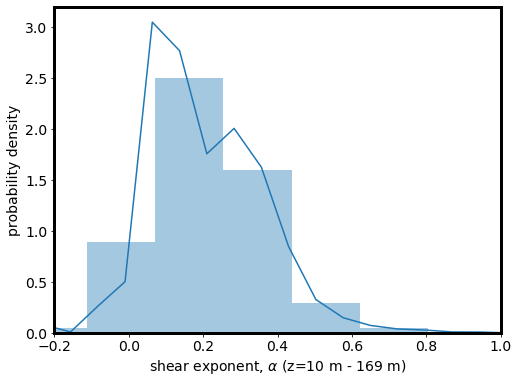

In [25]:
fig=plt.figure(figsize=(8,6), linewidth=3)
plt.rcParams['axes.linewidth'] = 3
ax=sns.distplot(df['C1']['alpha_10m_169m'].dropna())
plt.xlim(-.2,1)
plt.xlabel(r'shear exponent, $\alpha$ (z=10 m - 169 m)',fontsize=14)
plt.ylabel('probability density',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [26]:
ind_alpha_check=(df['C1']['alpha_10m_169m']> 1) | (df['C1']['alpha_10m_169m'] < -0.2) 
df['C1'].alpha_10m_169m[ind_alpha_check]=np.nan

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <a list of 10 Text yticklabel objects>)

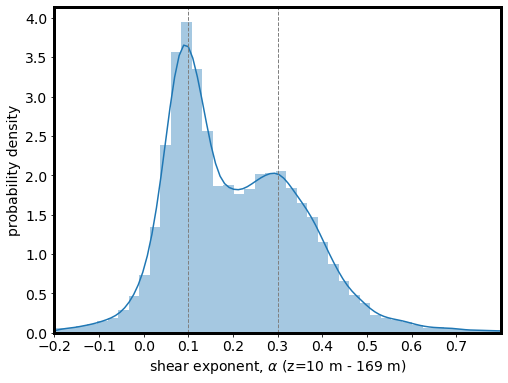

In [27]:
fig=plt.figure(figsize=(8,6), linewidth=3)
ax=sns.distplot(df['C1']['alpha_10m_169m'].dropna(),hist=True, kde=True, norm_hist=False )
ax.axvline(x=.1, color='gray',linestyle='--',lw=1,label='target wind direction')
ax.axvline(x=.3, color='gray',linestyle='--',lw=1,label='target wind direction')
plt.xlim(-0.2,0.8)
plt.xlabel(r'shear exponent, $\alpha$ (z=10 m - 169 m)',fontsize=14)
plt.ylabel('probability density',fontsize=14)
plt.xticks(np.arange(-0.2, 0.8, step=.1),fontsize=14)
plt.yticks(fontsize=14)


In [28]:
ecor_C1.head()

,time,ustar,qc_ustar,mean_t,qc_mean_t,cp,qc_cp,rho,qc_rho,sensible_heatflux,qc_sensible_heatflux,cvar_rot_wt
0,2018-06-01 00:00:00,0.1422,0.0,308.5,0.0,1040.0,0.0,1.084,0.0,16.030,0.0,0.011650
1,2018-06-01 00:30:00,0.2229,0.0,308.1,0.0,1043.0,0.0,1.084,0.0,15.840,0.0,0.011480
2,2018-06-01 01:00:00,0.1309,0.0,306.9,0.0,1048.0,0.0,1.087,0.0,4.274,0.0,0.003076
3,2018-06-01 01:30:00,0.1433,0.0,305.5,0.0,1048.0,0.0,1.092,0.0,-17.460,0.0,-0.012510
4,2018-06-01 02:00:00,0.1141,0.0,304.6,0.0,1048.0,0.0,1.095,0.0,-11.950,0.0,-0.008534


In [29]:
ecor_C1.set_index('time', inplace=True)
ecor_E37.set_index('time', inplace=True)
ecor_E39.set_index('time', inplace=True)

In [30]:
ecor_C1["Monin_Obukhov_length"]=ecor_C1.ustar**3*ecor_C1.mean_t/(0.4*9.8*ecor_C1.sensible_heatflux/(ecor_C1.rho*ecor_C1.cp))
ecor_C1["Monin_Obukhov_stability_parameter"]=3/ecor_C1["Monin_Obukhov_length"]
ecor_C1["cvar_tw"]=ecor_C1.sensible_heatflux/(ecor_C1.rho*ecor_C1.cp)

ecor_E37["Monin_Obukhov_length"]=ecor_E37.ustar**3*ecor_E37.mean_t/(0.4*9.8*ecor_E37.sensible_heatflux/(ecor_E37.rho*ecor_E37.cp))
ecor_E37["Monin_Obukhov_stability_parameter"]=3/ecor_E37["Monin_Obukhov_length"]
ecor_E37["cvar_tw"]=ecor_E37.sensible_heatflux/(ecor_E37.rho*ecor_E37.cp)


ecor_E39["Monin_Obukhov_length"]=ecor_E39.ustar**3*ecor_E39.mean_t/(0.4*9.8*ecor_E39.sensible_heatflux/(ecor_E39.rho*ecor_E39.cp))
ecor_E39["Monin_Obukhov_stability_parameter"]=3/ecor_E39["Monin_Obukhov_length"]
ecor_E39["cvar_tw"]=ecor_E39.sensible_heatflux/(ecor_E39.rho*ecor_E39.cp)

In [31]:
ecor_C1=ecor_C1.replace(np.Inf, np.nan)
ecor_C1=ecor_C1.replace(-np.Inf, np.nan)
ecor_E37=ecor_E37.replace(np.Inf, np.nan)
ecor_E37=ecor_E37.replace(-np.Inf, np.nan)
ecor_E39=ecor_E39.replace(np.Inf, np.nan)
ecor_E39=ecor_E39.replace(-np.Inf, np.nan)

In [32]:
ecor_C1["Monin_Obukhov_stability_parameter"].min()

-240.2890469562753

(-0.2, 0.2)

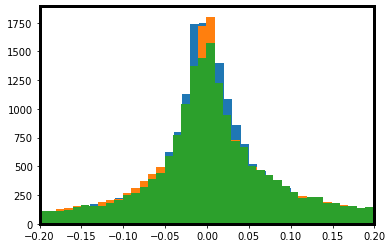

In [33]:
index=(ecor_C1["Monin_Obukhov_stability_parameter"] > .5) | (ecor_C1["Monin_Obukhov_stability_parameter"] < -.5)
ecor_C1[index]=np.nan

plt.hist(ecor_C1["Monin_Obukhov_stability_parameter"].dropna(),100)
plt.xlim(-0.2,0.2)

index=(ecor_E37["Monin_Obukhov_stability_parameter"] > .5) | (ecor_E37["Monin_Obukhov_stability_parameter"] < -.5)
ecor_E37[index]=np.nan

plt.hist(ecor_E37["Monin_Obukhov_stability_parameter"].dropna(),100)
plt.xlim(-0.2,0.2)

index=(ecor_E39["Monin_Obukhov_stability_parameter"] > .5) | (ecor_E39["Monin_Obukhov_stability_parameter"] < -.5)
ecor_E39[index]=np.nan

plt.hist(ecor_E39["Monin_Obukhov_stability_parameter"].dropna(),100)
plt.xlim(-0.2,0.2)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


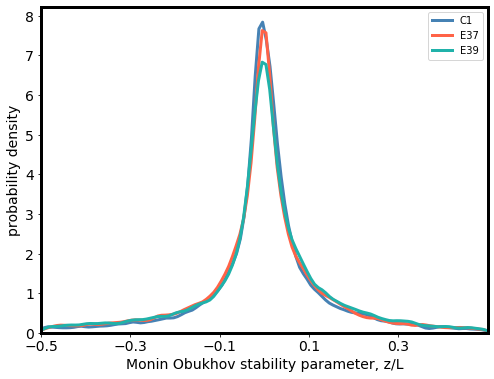

In [34]:
fig=plt.figure(figsize=(8,6), linewidth=3)
ax=sns.distplot(ecor_C1["Monin_Obukhov_stability_parameter"].dropna(), norm_hist=True, color="steelblue", kde_kws=dict(linewidth=3), hist=False,label='C1')
ax=sns.distplot(ecor_E37["Monin_Obukhov_stability_parameter"].dropna(), norm_hist=True, color="tomato", kde_kws=dict(linewidth=3), hist=False,label='E37')
ax=sns.distplot(ecor_E39["Monin_Obukhov_stability_parameter"].dropna(), norm_hist=True, color="lightseagreen", kde_kws=dict(linewidth=3), hist=False,label='E39')

plt.xlim(-0.5,0.5)
plt.xlabel('Monin Obukhov stability parameter, z/L',fontsize=14)
plt.ylabel('probability density',fontsize=14)
plt.xticks(np.arange(-0.5, 0.5, step=.2),fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

In [35]:
ecor_C1["Monin_Obukhov_stability_parameter"].median()

-0.0001044040578176469

In [36]:
ecor_E37.head()

,ustar,qc_ustar,mean_t,qc_mean_t,cp,qc_cp,rho,qc_rho,sensible_heatflux,qc_sensible_heatflux,cvar_rot_wt,Monin_Obukhov_length,Monin_Obukhov_stability_parameter,cvar_tw
time,,,,,,,,,,,,,,
2018-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 00:30:00,0.1430,0.0,304.4,0.0,1038.0,0.0,1.090,0.0,-16.73,0.0,-0.01212,-15.356583,-0.195356,-0.014787
2018-06-01 01:00:00,0.1476,0.0,302.5,0.0,1040.0,0.0,1.096,0.0,-26.35,0.0,-0.01894,-10.734002,-0.279486,-0.023117
2018-06-01 01:30:00,0.1104,0.0,300.3,0.0,1043.0,0.0,1.103,0.0,-15.61,0.0,-0.01111,-7.596847,-0.394901,-0.013569
2018-06-01 02:00:00,0.1125,0.0,299.2,0.0,1044.0,0.0,1.107,0.0,-20.56,0.0,-0.01457,-6.108831,-0.491092,-0.017790


In [37]:
df['C1']['Monin_Obukhov_stability_parameter']=ecor_C1["Monin_Obukhov_stability_parameter"].copy()
df['C1']['ustar']=ecor_C1["ustar"].copy()
df['C1']['temperature']=ecor_C1["mean_t"].copy()
df['C1']['cvar_tw']=ecor_C1["cvar_tw"].copy()

df['E37']['Monin_Obukhov_stability_parameter']=ecor_E37["Monin_Obukhov_stability_parameter"].copy()
df['E37']['ustar']=ecor_E37["ustar"].copy()
df['E37']['temperature']=ecor_E37["mean_t"].copy()
df['E37']['cvar_tw']=ecor_E37["cvar_tw"].copy()

df['E39']['Monin_Obukhov_stability_parameter']=ecor_E39["Monin_Obukhov_stability_parameter"].copy()
df['E39']['ustar']=ecor_E39["ustar"].copy()
df['E39']['temperature']=ecor_E39["mean_t"].copy()
df['E39']['cvar_tw']=ecor_E39["cvar_tw"].copy()

In [38]:
df['C1'].head()

,wspd_91m,wdir_91m,vert_ws_91m,wspd_169m,wdir_169m,vert_ws_169m,wspd_10m,wdir_10m,alpha_10m_169m,veer_10m_169m,Monin_Obukhov_stability_parameter,ustar,temperature,cvar_tw
time,,,,,,,,,,,,,,
2018-06-01 00:00:00,1.501558,174.724000,-0.024011,1.575568,161.978150,0.337331,1.463333,184.900000,0.026137,0.112234,0.188506,0.1422,308.5,0.014219
2018-06-01 00:30:00,3.300664,187.778380,0.080828,3.253631,189.273220,0.246315,2.306667,171.466660,0.121659,0.946964,0.048287,0.2229,308.1,0.014010
2018-06-01 01:00:00,4.503373,137.623580,0.011857,4.466671,140.371060,0.014607,2.743334,122.666664,0.172414,1.723337,0.064097,0.1309,306.9,0.003752
2018-06-01 01:30:00,5.679764,102.382256,0.108431,5.551931,111.516020,0.169127,3.300000,95.666664,0.183999,2.251932,-0.199580,0.1433,305.5,-0.015257
2018-06-01 02:00:00,5.857873,106.696540,0.105633,5.724772,118.249695,0.133231,2.543333,96.566666,0.286960,3.181439,-0.270653,0.1141,304.6,-0.010413


(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 9 Text yticklabel objects>)

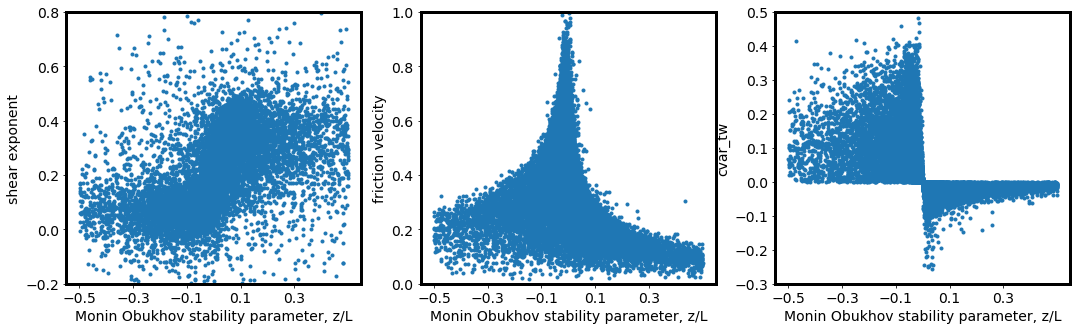

In [39]:
fig=plt.figure(figsize=(18,5))
ax  = fig.add_subplot(131)
plt.plot((-1)*df['C1']['Monin_Obukhov_stability_parameter'],df['C1'].alpha_10m_169m,'.')
plt.ylim(-0.2,0.8)
plt.xlabel('Monin Obukhov stability parameter, z/L',fontsize=14)
plt.ylabel('shear exponent',fontsize=14)
plt.xticks(np.arange(-0.5, 0.5, step=.2),fontsize=14)
plt.yticks(fontsize=14)
ax  = fig.add_subplot(132)
plt.plot((-1)*df['C1']['Monin_Obukhov_stability_parameter'],df['C1'].ustar,'.')
plt.ylim(0,1)
plt.xlabel('Monin Obukhov stability parameter, z/L',fontsize=14)
plt.ylabel('friction velocity',fontsize=14)
plt.xticks(np.arange(-0.5, 0.5, step=.2),fontsize=14)
plt.yticks(fontsize=14)
ax  = fig.add_subplot(133)
plt.plot((-1)*df['C1']['Monin_Obukhov_stability_parameter'],df['C1'].cvar_tw,'.')
plt.ylim(-0.3,0.5)
plt.xlabel('Monin Obukhov stability parameter, z/L',fontsize=14)
plt.ylabel('cvar_tw',fontsize=14)
plt.xticks(np.arange(-0.5, 0.5, step=.2),fontsize=14)
plt.yticks(fontsize=14)

In [40]:
instrum='C1'
index_unstable=df[instrum]['Monin_Obukhov_stability_parameter'] > 0.002
index_stable=df[instrum]['Monin_Obukhov_stability_parameter'] < -0.002
index_neutral=(df[instrum]['Monin_Obukhov_stability_parameter'] < 0.002) & (df[instrum]['Monin_Obukhov_stability_parameter'] > -0.001)

In [41]:
count_unstable=df[instrum].Monin_Obukhov_stability_parameter[index_unstable].count()/df[instrum].Monin_Obukhov_stability_parameter.count()*100
count_stable=df[instrum].Monin_Obukhov_stability_parameter[index_stable].count()/df[instrum].Monin_Obukhov_stability_parameter.count()*100
count_neutral=df[instrum].Monin_Obukhov_stability_parameter[index_neutral].count()/df[instrum].Monin_Obukhov_stability_parameter.count()*100
count=[count_unstable,count_neutral,count_stable]
label=['unstable','neutral', 'stable']

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text yticklabel objects>)

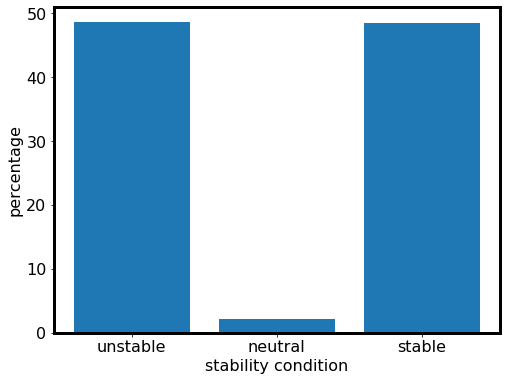

In [42]:
fig=plt.figure(figsize=(8,6), linewidth=3)
plt.bar(label, count)
plt.ylabel('percentage', fontsize=16)
plt.xlabel('stability condition', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


**Wind direction selection**

In [43]:
df_selected={}
half_bin=10
index=(df['C1'].wdir_91m < 173+half_bin) & (df['C1'].wdir_91m >173-half_bin)

df_selected['C1']=df['C1'][index]

In [44]:
df_selected['C1'].columns

Index(['wspd_91m', 'wdir_91m', 'vert_ws_91m', 'wspd_169m', 'wdir_169m',
       'vert_ws_169m', 'wspd_10m', 'wdir_10m', 'alpha_10m_169m',
       'veer_10m_169m', 'Monin_Obukhov_stability_parameter', 'ustar',
       'temperature', 'cvar_tw'],
      dtype='object')

In [45]:
df_selected['C1'].Monin_Obukhov_stability_parameter.head()

time
2018-06-01 00:00:00    0.188506
2018-06-01 14:30:00    0.067652
2018-06-01 16:30:00    0.117624
2018-06-01 19:00:00    0.081602
2018-06-01 20:00:00    0.062218
Name: Monin_Obukhov_stability_parameter, dtype: float64

**Case selection**

In [46]:
index_unstable=df_selected['C1'].Monin_Obukhov_stability_parameter > 0.002
index_neutral=(df_selected['C1'].Monin_Obukhov_stability_parameter < 0.002) & (df_selected['C1'].Monin_Obukhov_stability_parameter > -0.002)
index_stable=df_selected['C1'].Monin_Obukhov_stability_parameter < -0.002

**Unstable case**

In [47]:
df_selected['C1'][index_unstable].mean()

wspd_91m                               7.781448
wdir_91m                             174.121293
vert_ws_91m                           -0.095810
wspd_169m                              8.372415
wdir_169m                            177.823032
vert_ws_169m                          -0.056374
wspd_10m                               6.106132
wdir_10m                             187.383358
alpha_10m_169m                         0.113167
veer_10m_169m                          2.260462
Monin_Obukhov_stability_parameter      0.073762
ustar                                  0.432142
temperature                          301.255379
cvar_tw                                0.103301
dtype: float64

**Neutral case**

In [48]:
df_selected['C1'][index_neutral].mean()

wspd_91m                              11.145586
wdir_91m                             173.561812
vert_ws_91m                           -0.180587
wspd_169m                             12.555890
wdir_169m                            178.128249
vert_ws_169m                          -0.165358
wspd_10m                               7.763109
wdir_10m                             184.261797
alpha_10m_169m                         0.179629
veer_10m_169m                          4.714392
Monin_Obukhov_stability_parameter     -0.000042
ustar                                  0.540861
temperature                          299.392391
cvar_tw                               -0.001068
dtype: float64

**Stable case**

In [49]:
df_selected['C1'][index_stable].mean()

wspd_91m                               9.832039
wdir_91m                             172.580482
vert_ws_91m                           -0.163019
wspd_169m                             12.071382
wdir_169m                            174.980795
vert_ws_169m                          -0.115778
wspd_10m                               5.298774
wdir_10m                             164.445079
alpha_10m_169m                         0.296575
veer_10m_169m                          6.755082
Monin_Obukhov_stability_parameter     -0.058661
ustar                                  0.346666
temperature                          300.176215
cvar_tw                               -0.031667
dtype: float64

**Use surface flux station data**

In [ ]:
ecorsf_E39.head()

In [ ]:
plt.hist(ecorsf_E37.qc_air_temperature)

In [ ]:
ecorsf_E37.Monin_Obukhov_length

In [ ]:
plt.hist(ecorsf_E37.Monin_Obukhov_length.values,500)

In [ ]:
plt.hist(ecorsf_E37.Monin_Obukhov_stability_parameter,2000,density=True)
plt.xlim(-0.5,0.5)